  0%|          | 0/11613 [00:00<?, ?it/s]

torch.Size([1, 1, 128, 128])
tensor(1., device='cuda:0') tensor(0.2231, device='cuda:0')
('case33_day0_0090.png',)


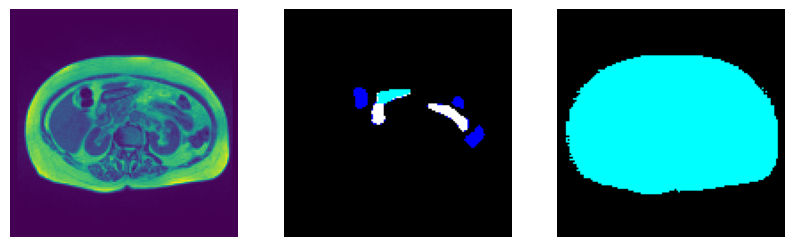

  0%|          | 0/11613 [00:00<?, ?it/s]


In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from gi_tract_seg_2022.models import mscff
from tqdm import tqdm
from gi_tract_seg_2022.my_dataset import GIDataset
from torch.utils.data import DataLoader

def to_palette(data):
    cmap = {
        0: [0, 0, 0],
        1: [0, 0, 255],
        2: [255, 255, 255],
        3: [0, 255, 255]
    }
    data = data.detach().numpy()
    data = data.astype(np.uint8)
    rgb = np.zeros((data.shape[0], data.shape[1], 3), np.uint8)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            rgb[i, j, :] = cmap[data[i, j]]
    return rgb

plt.rcParams.update({'font.size': 22})

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 1
pth = "/root/qiyuan/codes/my-kaggle/data/tflogs/20230411045759/E004.pth"
src_dir = "/data/qiyuan_data/uw-madison-gi-tract-image-segmentation/ds_has_target/train"
net = mscff.MSCFF(1, 4)
net.to(device=device)
net.load_state_dict(torch.load(pth, map_location=device))
net.eval()
dataset = GIDataset(
    src_dir,
    return_name=True,
    random_aug=False,
    mixup=False,
    target_shape=(128, 128),
    sample_ratio=None
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n = 0
for batch in tqdm(loader):
    imgs, mask, name = batch
    imgs = imgs.to(device=device, dtype=torch.float32)
    mask = mask.to(device=device, dtype=torch.long)
    mask_pred = net(imgs)

    img_gt = to_palette(torch.squeeze(mask.cpu()))
    mask_pred = torch.argmax(mask_pred, axis=1)
    img_pred = to_palette(torch.squeeze(mask_pred.cpu()))

    print(imgs.shape)
    print(torch.max(imgs), torch.mean(imgs))
    print(name)

    img = np.squeeze(imgs[0, :, :, :].cpu().numpy())
    img = np.clip(img * 255, 0, 255)
    img = img.astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(img_gt)
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(img_pred)
    plt.show()
    break